In [1]:
"""
Created on Fri Feb 17 18:26:56 2023

@author: FGonzalez
"""

#importar librerías
import os

import pandas as pd

import matplotlib.pyplot as plt

import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import acf

import pmdarima as pm

In [2]:
#lectura del archivo
birthdays = pd.read_csv('US_births_1994-2014.csv')


In [3]:
#convertir las columnas de año, mes y dia a un string
birthdays['date']=birthdays['year'].astype(str)+"-"+birthdays['month'].astype(str)+"-"+birthdays['date_of_month'].astype(str)

#convertir la columna string a tipo datetime
birthdays['date'] =pd.to_datetime(birthdays['date'])

#definir la columna date como indice
birthdays=birthdays.set_index('date')


<AxesSubplot: xlabel='date'>

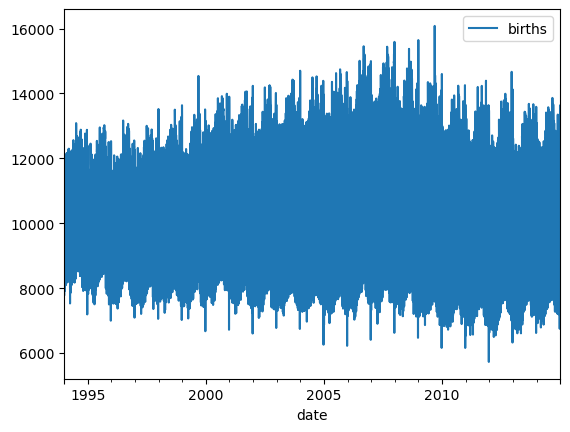

In [4]:
#graficar la serie de tiempo como viene (por día)
birthdays.plot(y='births')

<AxesSubplot: xlabel='date'>

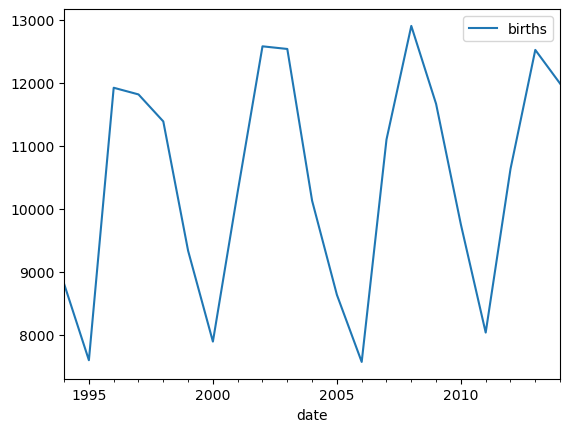

In [5]:
#graficar la serie de tiempo agrupada por año
birthdays.asfreq('Y').plot(y='births')

<AxesSubplot: xlabel='date'>

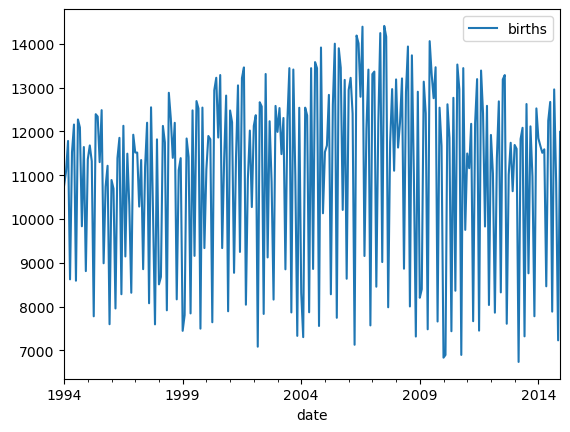

In [6]:
#graficar la serie de tiempo agrupada por mes
birthdays.asfreq('M').plot(y='births')

<AxesSubplot: xlabel='date'>

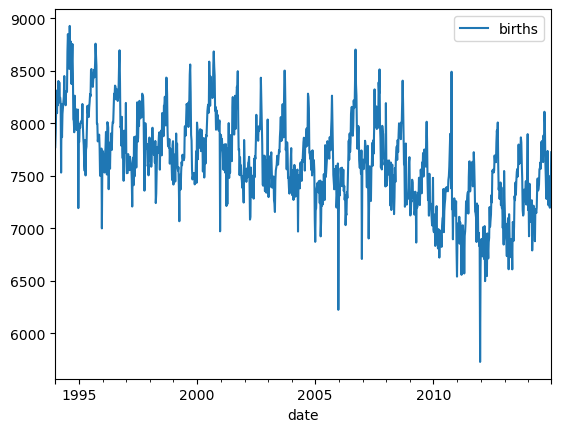

In [7]:
#graficar la serie de tiempo agrupada por semana
birthdays.asfreq('W').plot(y='births')

In [8]:
#asignar los datos agrupados semanalmente a una variable
birthdays_weekly=birthdays.asfreq('W')

#filtrar los datos a partir del año 2007
birthdays_weekly_recent=birthdays_weekly['2007':]


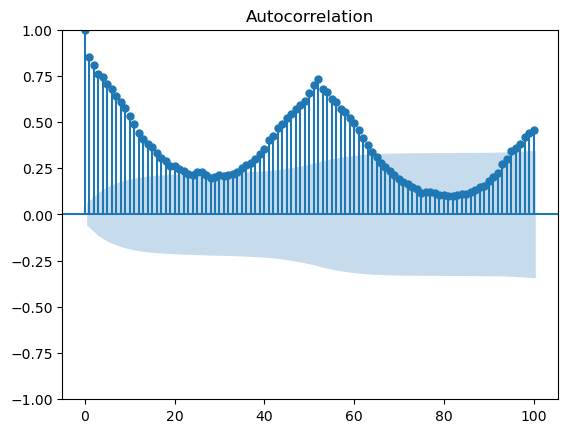

In [9]:
#realizar grafico acf
plot_acf(birthdays_weekly['births'],lags=100)
plt.show()



In [10]:
#obtener datos acf para ver exactamente en donde esta el maximo
acf_data=acf(birthdays_weekly['births'],nlags=100)

acf_data=pd.DataFrame(acf_data,columns=['acf'])

print(acf_data.head(60))



         acf
0   1.000000
1   0.849571
2   0.809458
3   0.761723
4   0.745343
5   0.705222
6   0.679101
7   0.641789
8   0.609428
9   0.577371
10  0.530282
11  0.491084
12  0.438701
13  0.408911
14  0.382230
15  0.363979
16  0.332976
17  0.307871
18  0.289014
19  0.263975
20  0.264036
21  0.246472
22  0.236673
23  0.219572
24  0.213762
25  0.227580
26  0.231279
27  0.214366
28  0.199328
29  0.202276
30  0.212652
31  0.208743
32  0.211315
33  0.221198
34  0.231951
35  0.251489
36  0.266589
37  0.276424
38  0.301767
39  0.326242
40  0.356946
41  0.400523
42  0.425504
43  0.466722
44  0.488395
45  0.521007
46  0.545606
47  0.568834
48  0.593505
49  0.614969
50  0.659220
51  0.702354
52  0.735792
53  0.677397
54  0.664811
55  0.624733
56  0.608400
57  0.570490
58  0.554958
59  0.523419


In [11]:
test_size=50

#separar los datos en datos de prueba y de entrenamiento
train_y=birthdays_weekly_recent['births'].iloc[0:-test_size]
test_y=birthdays_weekly_recent['births'].iloc[-test_size:]

In [12]:
#en el grafico acf vimos que la autocorrelacion máxima está en 52, por lo que se considera que la data tiene una estacionalidad
#de 52 semanas

m=52

#entrenar modelo arima

arima = pm.auto_arima(train_y, out_of_sample_size =test_size, trace=False,
                      suppress_warnings=True, 
                      seasonal=True, m=m)

In [13]:
#imprimir sumario del modelo 
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  367
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood               -2473.088
Date:                             Mon, 27 Feb 2023   AIC                           4952.175
Time:                                     07:11:44   BIC                           4963.883
Sample:                                          0   HQIC                          4956.828
                                             - 367                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6165      0.036    -17.050      0.000      -0.687      -0.546
ar.S.L52       0.3627      0.038      9.624      0.000       0.289       0.437
sigma2      4.359e+04   1962.778     22.210      0.000    3.97e+04    4.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               245.03
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.30
Prob(H) (two-sided):                  0.81   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

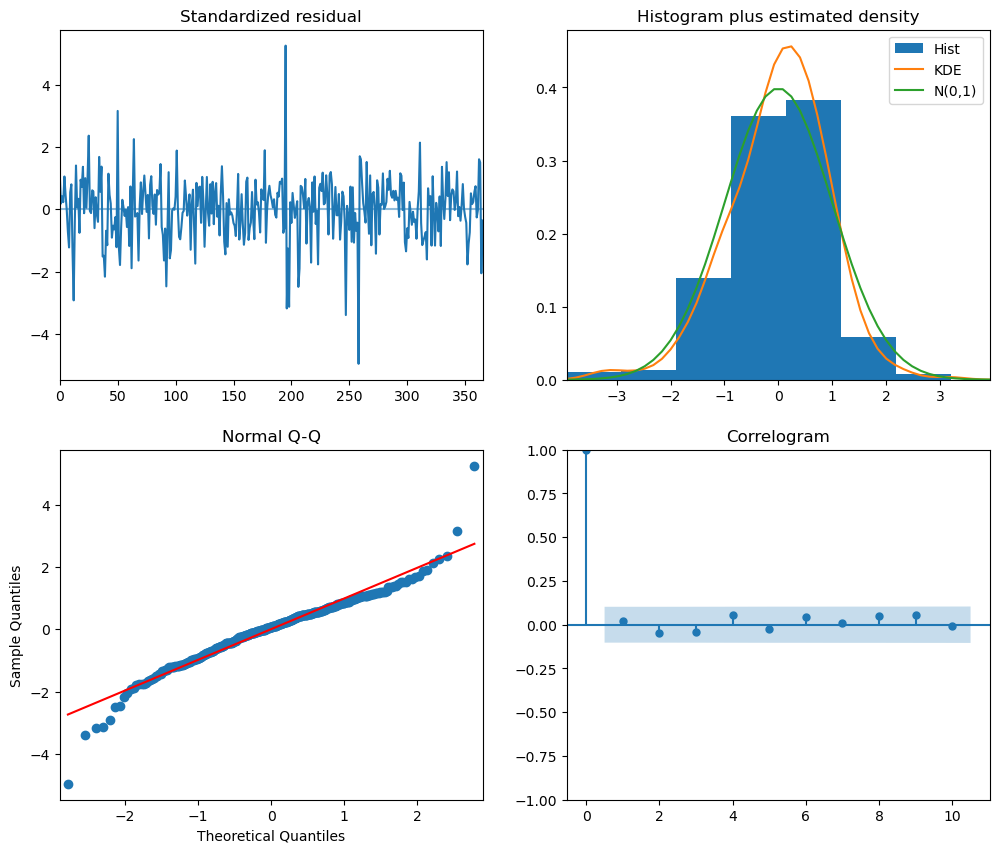

In [14]:
#grafico de diagnósticos
arima.plot_diagnostics(figsize=(12,10))
plt.show()

In [15]:
#predecir resultados
results=arima.predict(n_periods=test_size,return_conf_int=True)

results_df=pd.DataFrame(results[0],columns=['prediction'])

results_df.index=test_y.index


conf_int_df=pd.DataFrame(results[1],columns=['lower','upper'])

conf_int_df.index=test_y.index

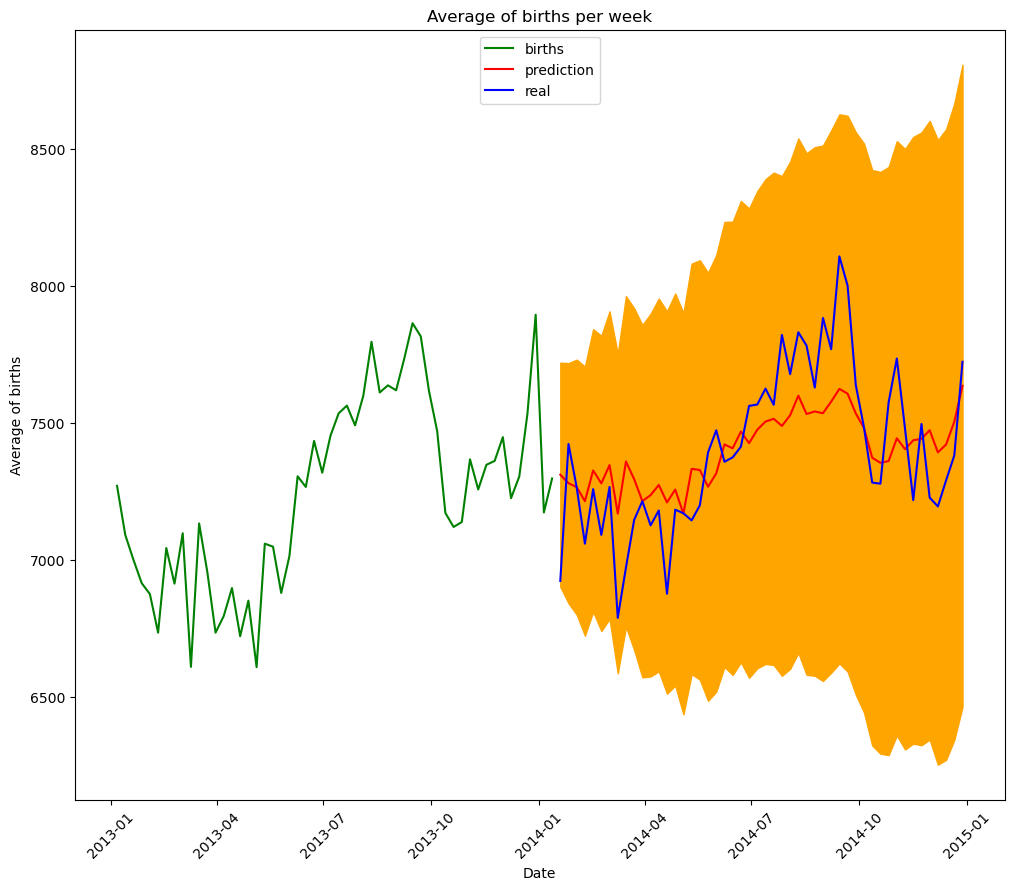

In [21]:
#filtrar datos originales para el gráfico
birthdays_weekly_recent_plot=train_y['2013':]

#graficar prediccion usando matplotlib
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(birthdays_weekly_recent_plot,label='births',color='green')
ax.plot(results_df,label='prediction',color='red')
ax.plot(test_y,label='real',color='blue')
ax.fill_between(conf_int_df.index,conf_int_df['lower'],conf_int_df['upper'],color='orange')
ax.legend(loc='upper center')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Average of births')
plt.title('Average of births per week')
plt.show()

In [31]:
#graficar prediccion usando plotly


fig = go.Figure()

fig.add_trace(go.Scatter(x=birthdays_weekly_recent_plot.index, y=birthdays_weekly_recent_plot, mode='lines', name='births', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test_y.index, y=results_df['prediction'], mode='lines', name='prediction', line=dict(color='red')))
fig.add_trace(go.Scatter(x=test_y.index, y=test_y, mode='lines', name='real', line=dict(color='blue')))

fig.add_trace(go.Scatter(x=test_y.index, y=conf_int_df['upper'], mode='lines', name='upper bound', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test_y.index, y=conf_int_df['lower'], mode='lines', name='lower bound', line=dict(color='orange')))

fig.update_layout(title='Average of births per week', xaxis_title='Date', yaxis_title='Average of births', xaxis_tickangle=-45)

fig.show()